# Keras 利用資料擴增法訓練貓狗分類器

## 透過 Kaggle API 下載 Play Dataset

先從 Kaggle 下載資料集，這裡需要註冊 Kaggle 的帳號，並且取得 API Key，記得置換為自己的 API Token 才能下載資料。

In [4]:
#!pip install kaggle
api_token = {"username":"your_username","key":"your_api_key"}
import json
import zipfile
import os

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images

!unzip 'dogs-cats-images.zip' > /dev/null

100% 433M/435M [00:14<00:00, 34.5MB/s]
100% 435M/435M [00:14<00:00, 31.3MB/s]


看看資料的基本結構，貓與狗訓練資料夾各有 4000 張，測試資料夾各有 1000 張影像



In [5]:
!echo "training_set cats: "
!echo `ls -alh '/kaggle/dataset/training_set/cats' | grep cat | wc -l`
!echo "training_set dogs: "
!echo `ls -alh '/kaggle/dataset/training_set/dogs' | grep dog | wc -l`
!echo "test_set cats: "
!echo `ls -alh '/kaggle/dataset/test_set/cats' | grep cat | wc -l`
!echo "test_set dogs: "
!echo `ls -alh '/kaggle/dataset/test_set/dogs' | grep dog | wc -l`

training_set cats: 
4000
training_set dogs: 
4000
test_set cats: 
1000
test_set dogs: 
1000


## 資料處理

我們上面從 Kaggle 下載的檔案全部都是圖片，由於我們想要從頭訓練一個可以分辨貓或狗的 CNN 網路，開始以前需要先將影像資料進行處理，轉換為可以送進 Keras 網路進行訓練的「張量」。並且依據我們選用的損失函數方法，處理對應標準答案的格式。

由於我們今天不會用到全部的資料，我們只會在兩種類別取用 1000 張進行訓練，500 張進行測試。接著利用「資料擴增工法」來提高正確率。

In [0]:


import os, shutil

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/kaggle/dataset'

# The directory where we will
# store our smaller dataset
base_dir = '/play'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1, 1001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'training_set', 'cats', fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(4001, 4501)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'cats', fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(4501, 5001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'cats', fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1, 1001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'training_set', 'dogs', fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(4001, 4501)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'dogs', fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(4501, 5001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'dogs', fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


接著建構我們需要的網路，使用四層網路組合 CNN，最後的 Full Connection Layer 使用 512 個神經元，Keras 建立 CNN 網路的方法如下：

In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


顯示網路的組成架構，整個網路有 3,453,121 個參數需要訓練，這樣的運算量非常需要高速的 GPU 來協助運算。

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

這次要解決的問題屬於「二元分類」，算是 CNN 裡最典型的問題，因此損失函式採用「binary_crossentropy」，優化器選用「RMSprop」

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

再來定義 ImageDataGenerator，ImageDataGenerator 是 Keras 用來讀取影像資料的方法，可以想像為 Dataset Provider 的概念，這樣可以不需要把所有資料都讀進記憶體，如果要訓練的資料影像很多，這會是一個解套的好方。這裡我們只是利用 ImageDataGenerator 來走訪需要訓練的資料，稍後會用來產生更多資料提高模型訓練準確度。

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


# 訓練 CNN 網路

剛剛的 batch_size 設定 20，表示每次從 train_generator 抓 20 筆資料送進 Network 進行訓練
我們有 2000 筆資料 (貓與狗各 1000 筆)，一共要做 100 次才會做完，這樣訓練一輪就是一個 epoch，訓練如下：

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 15s 147ms/step - loss: 0.6895 - acc: 0.5360 - val_loss: 0.6863 - val_acc: 0.5900
Epoch 2/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6580 - acc: 0.6160 - val_loss: 0.6729 - val_acc: 0.6550
Epoch 3/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6060 - acc: 0.6695 - val_loss: 0.7471 - val_acc: 0.6740
Epoch 4/30
100/100 [==============================] - 8s 84ms/step - loss: 0.5634 - acc: 0.7100 - val_loss: 0.6494 - val_acc: 0.7040
Epoch 5/30
100/100 [==============================] - 8s 83ms/step - loss: 0.5358 - acc: 0.7355 - val_loss: 0.9112 - val_acc: 0.6740
Epoch 6/30
100/100 [==============================] - 8s 82ms/step - loss: 0.5092 - acc: 0.7485 - val_loss: 0.4133 - val_acc: 0.7230
Epoch 7/30
100/100 [==============================] - 8s 82ms/step - loss: 0.4740 - acc: 0.7705 - val_loss: 0.6692 - val_acc: 0.7020
Epoch 8/30
100/100 [==============================] - 8s 84ms/step 

# 透過圖表分析模型狀態

觀察圖表分析訓練情況

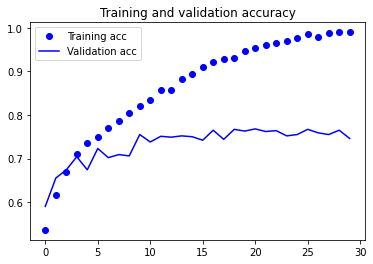

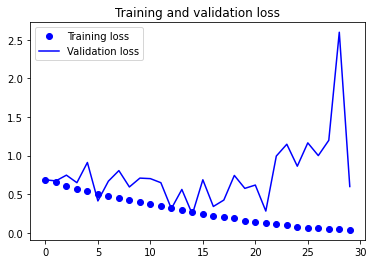

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

從上面的圖片可以發現，在 5 Epoch 之後就開始走針了，Model 已經出現 Over Fitting 的現象。接下來透過 ImageDataGenerator 來擴增訓練樣本數量。


## Keras 利用資料擴增法提高訓練準確性

由於我們總共只用了 2000 筆資料，假設樣本真的很難取得，那麼我們可以透過資料擴增法，將影像資料做一點「變化」，稍微加工一下這樣就有更多資料可以讓模型進行學習。Keras ImageDataGenerator 可以幫助我們實現影像資料擴增，如下：

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,             # 隨機旋轉的角度
      width_shift_range=0.2,         # 隨機水平平移的 % 比例
      height_shift_range=0.2,        # 隨機垂直平移的 % 比例
      shear_range=0.2,               # 隨機傾斜的角度
      zoom_range=0.2,                # 隨機縮放的比例
      horizontal_flip=True,          # 隨機左右翻轉
      fill_mode='nearest')           # 邊界像素填補，由於影像調整後周圍會出現缺少的像素，設定 nearest 會以最接近的像素填補

以下我們將每一張影像隨機進行變化，產生四張經過加工的圖片。這樣一來我們的資料集忽然就便多了，如下：

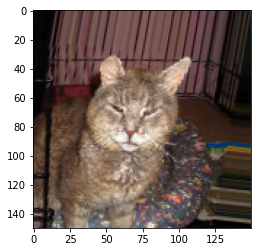

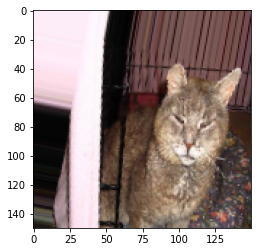

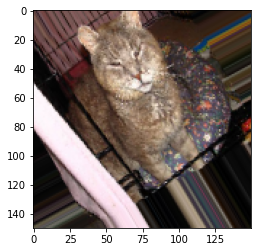

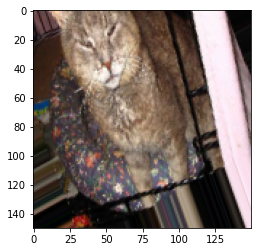

In [15]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

重新建立模型，這裡我們有動一點手腳，就是在卷積層傳入全連接層 (Full Connection Layer) 的時候加入了 Dropout Layer，這樣會隨機丟棄 50% 的資訊，用意是不要讓網路的學習過於狹隘，不然很容易造成 Over Fitting，如下：

In [16]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))                # 加入 Dropout 0.5 隨機丟棄 50%
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

進行模型訓練，這裡設定 batch_size=32, steps_per_epoch=100，相當於透過資料擴增法增加到 3,200 筆訓練資料，運算量很高，需要讓子彈飛一下，如下：

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 28s 281ms/step - loss: 0.6922 - acc: 0.5234 - val_loss: 0.6955 - val_acc: 0.6110
Epoch 2/100
100/100 [==============================] - 25s 253ms/step - loss: 0.6794 - acc: 0.5631 - val_loss: 0.6867 - val_acc: 0.6108
Epoch 3/100
100/100 [==============================] - 25s 255ms/step - loss: 0.6667 - acc: 0.5911 - val_loss: 0.7159 - val_acc: 0.5558
Epoch 4/100
100/100 [==============================] - 26s 255ms/step - loss: 0.6601 - acc: 0.5996 - val_loss: 0.6287 - val_acc: 0.6495
Epoch 5/100
100/100 [==============================] - 24s 241ms/step - loss: 0.6366 - acc: 0.6414 - val_loss: 0.5918 - val_acc: 0.6345
Epoch 6/100
100/100 [==============================] - 27s 274ms/step - loss: 0.6159 - acc: 0.6580 - val_loss: 0.5990 - val_acc: 0.7017
Epoch 7/100
100/100 [==============================] - 25s 254ms/step - loss: 0.5972 - acc: 0.6780 -

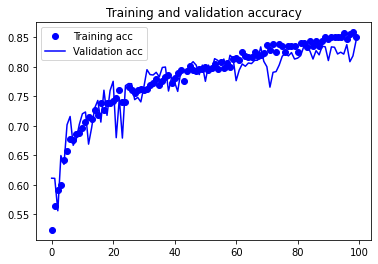

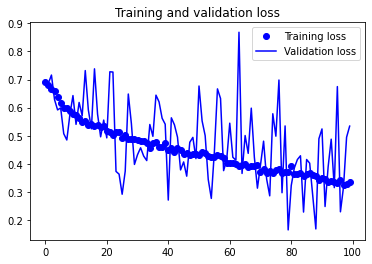

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

上圖，將貓與狗的訓練樣本由 2,000 擴增為 3,200，並且在網路最後一層 Dropout 50%，可將正確率由 0.7 提昇至 0.85。